# ***1. Import Necessary Libraries***


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import tensorflow as tf
import keras
import cv2
import random
import shutil

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNet

# ***2. FER2013 and AffectNet downloaded from Kaggle and extracted ***

In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013
!kaggle datasets download -d noamsegal/affectnet-training-data

#Extract FER
with zipfile.ZipFile('fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')

# Check the extracted files
for root, dirs, files in os.walk('fer2013'):
    for file in files:
        print(os.path.join(root, file))


# Extract AffectNet
with zipfile.ZipFile('affectnet-training-data.zip', 'r') as zip_ref:
    zip_ref.extractall('affectnet')


for root, dirs, files in os.walk('affectnet'):
    for file in files:
        print(os.path.join(root, file))



Streaming output truncated to the last 5000 lines.
affectnet/sad/image0018349.jpg
affectnet/sad/image0028269.jpg
affectnet/sad/image0000933.jpg
affectnet/sad/image0027403.jpg
affectnet/sad/image0021089.jpg
affectnet/sad/image0023057.jpg
affectnet/sad/image0017687.jpg
affectnet/sad/image0025287.jpg
affectnet/sad/image0027034.jpg
affectnet/sad/image0012459.jpg
affectnet/sad/image0016588.jpg
affectnet/sad/image0026172.jpg
affectnet/sad/image0017613.jpg
affectnet/sad/image0015325.jpg
affectnet/sad/image0027449.jpg
affectnet/sad/image0020009.jpg
affectnet/sad/image0012338.jpg
affectnet/sad/image0030041.jpg
affectnet/sad/image0000290.jpg
affectnet/sad/image0018083.jpg
affectnet/sad/image0018465.jpg
affectnet/sad/image0006107.jpg
affectnet/sad/image0015124.jpg
affectnet/sad/image0030336.jpg
affectnet/sad/image0013661.jpg
affectnet/sad/image0027345.jpg
affectnet/sad/image0018613.jpg
affectnet/sad/image0028177.jpg
affectnet/sad/image0020571.jpg
affectnet/sad/image0018393.jpg
affectnet/sad/image

# ***3. AffectNet Preprocessing***

In order to make AffectNet similar to FER2013, some operations was made.

*  Contempt, disgust and surprised emotions are not included. Anger, fear, happy, neutral and sad are kept.
*   Images resized 48x48 pixels from 96x96 pixels.

*   Converted grayscale from RGB.

*   Splitted test and train folders with a ratio of 0.8.

*  Shuffled to create a random distrubition.




In [4]:
# Define the emotions to keep and their mappings
affectnet_emotions_to_keep = ['anger', 'happy', 'neutral', 'sad']
emotion_mapping = {
    'anger': 'angry',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad'
}

# Preprocess AffectNet (resize, convert grayscale, split, shuffle)
def preprocess_affectnet_images(src_dir, train_dir, test_dir, target_size=(48, 48), split_ratio=0.8):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for emotion in affectnet_emotions_to_keep:
        class_dir = os.path.join(src_dir, emotion)
        train_class_dir = os.path.join(train_dir, emotion_mapping[emotion])
        test_class_dir = os.path.join(test_dir, emotion_mapping[emotion])

        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)

        files = os.listdir(class_dir)
        random.shuffle(files)
        split_point = int(len(files) * split_ratio)

        for img_name in tqdm(files[:split_point], desc=f'Processing {emotion} - Train'):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, target_size)
            cv2.imwrite(os.path.join(train_class_dir, img_name), resized_img)

        for img_name in tqdm(files[split_point:], desc=f'Processing {emotion} - Test'):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, target_size)
            cv2.imwrite(os.path.join(test_class_dir, img_name), resized_img)

# Paths
affectnet_src_dir = "affectnet/"
affectnet_train_preprocessed_dir = "affectnet_preprocessed/train/"
affectnet_test_preprocessed_dir = "affectnet_preprocessed/test/"

# Preprocess AffectNet images
preprocess_affectnet_images(affectnet_src_dir, affectnet_train_preprocessed_dir, affectnet_test_preprocessed_dir)

Processing sad - Test: 100%|██████████| 619/619 [00:00<00:00, 4214.85it/s]


# ***4. Checked the number of data in each dataset***

In [5]:
fer_train = 'fer2013/train/'
fer_test = 'fer2013/test/'

affect_train = 'affectnet_preprocessed/train/'
affect_test = 'affectnet_preprocessed/test/'

# Function to check if anything is missing
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

In [6]:
fer_tr_count = Classes_Count(fer_train, 'Train').transpose().sort_values(by="Train", ascending=False)
fer_ts_count = Classes_Count(fer_test, 'Test').transpose().sort_values(by="Test", ascending=False)

affect_tr_count = Classes_Count(affect_train, 'Train').transpose().sort_values(by="Train", ascending=False)
affect_ts_count = Classes_Count(affect_test, 'Test').transpose().sort_values(by="Test", ascending=False)

In [7]:
pd.concat([fer_tr_count,fer_ts_count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


In [8]:
pd.concat([affect_tr_count,affect_ts_count], axis=1)

,Train,Test
neutral,4100,1026
happy,4035,1009
angry,2574,644
sad,2472,619


# ***5. FER2013 and preprocessed AffectNet combined to same folder***

In [9]:
# Function to combine FER and AffectNet
def combine_datasets(src_dirs, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for src_dir in src_dirs:
        for emotion in os.listdir(src_dir):
            src_emotion_dir = os.path.join(src_dir, emotion)
            dest_emotion_dir = os.path.join(dest_dir, emotion)

            if not os.path.exists(dest_emotion_dir):
                os.makedirs(dest_emotion_dir)

            for img_name in tqdm(os.listdir(src_emotion_dir), desc=f'Copying {emotion} from {src_dir}'):
                src_img_path = os.path.join(src_emotion_dir, img_name)
                dest_img_path = os.path.join(dest_emotion_dir, img_name)
                shutil.copy(src_img_path, dest_img_path)

# Combined dataset paths
train_dir = 'dataset/train/'
test_dir = 'dataset/test'

combine_datasets([fer_train, affect_train], train_dir)

combine_datasets([fer_test, affect_test], test_dir)


Copying angry from affectnet_preprocessed/train/: 100%|██████████| 2574/2574 [00:00<00:00, 11343.88it/s]
Copying neutral from affectnet_preprocessed/train/: 100%|██████████| 4100/4100 [00:00<00:00, 10717.36it/s]
Copying angry from affectnet_preprocessed/test/: 100%|██████████| 644/644 [00:00<00:00, 11515.98it/s]
Copying neutral from affectnet_preprocessed/test/: 100%|██████████| 1026/1026 [00:00<00:00, 8862.96it/s]
Copying sad from affectnet_preprocessed/test/: 100%|██████████| 619/619 [00:00<00:00, 11553.68it/s]


# ***6. Remove Disgust,Fear and Surprised from combined dataset***


In [10]:
# Remove disgust and surprise emotions

def remove_unwanted_emotions(dataset_dir, emotions_to_remove):
    for emotion in emotions_to_remove:
        emotion_dir = os.path.join(dataset_dir, emotion)
        if os.path.exists(emotion_dir):
            shutil.rmtree(emotion_dir)
            print(f'Removed {emotion_dir}')


emotions_to_remove = ['disgust', 'surprise','fear']

remove_unwanted_emotions(train_dir, emotions_to_remove)
remove_unwanted_emotions(test_dir, emotions_to_remove)


Removed dataset/train/disgust
Removed dataset/train/surprise
Removed dataset/train/fear
Removed dataset/test/disgust
Removed dataset/test/surprise
Removed dataset/test/fear


# ***7. Visualizing Images***

Random 5 images in each class are visualized for check purposes.

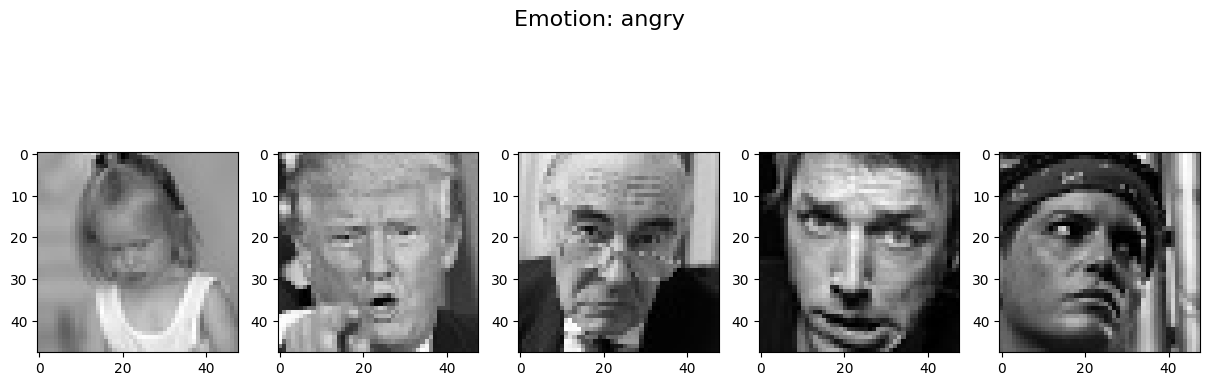

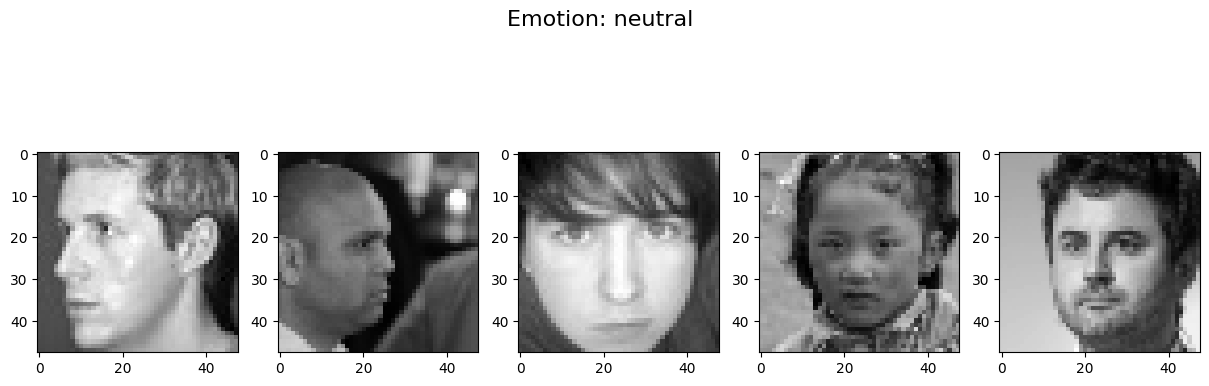

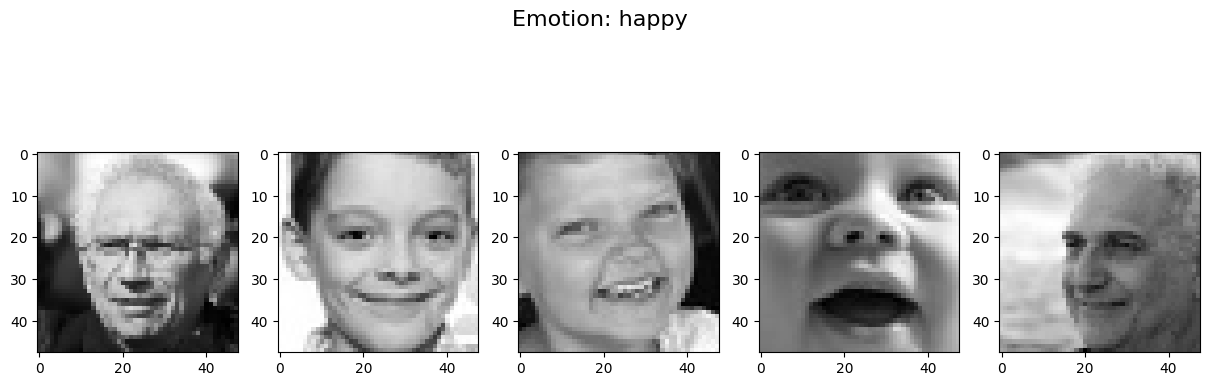

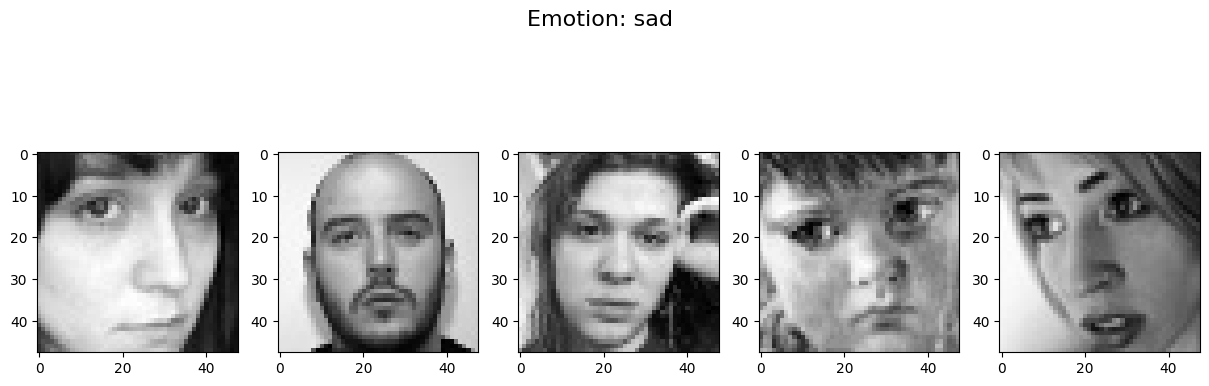

In [11]:
# Visualize images

def show_images_from_dataset(dataset_dir, num_images=5):
    emotions = os.listdir(dataset_dir)
    for emotion in emotions:
      if emotion[0] != '.': #skip hidden files
          emotion_dir = os.path.join(dataset_dir, emotion)
          img_names = os.listdir(emotion_dir)
          random.shuffle(img_names)

          plt.figure(figsize=(15, 5))
          plt.suptitle(f'Emotion: {emotion}', fontsize=16)

          for i in range(num_images):
              img_path = os.path.join(emotion_dir, img_names[i])
              img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
              if img is not None:
                  plt.subplot(1, num_images, i + 1)
                  plt.imshow(img, cmap='gray')

          plt.show()



show_images_from_dataset(train_dir)

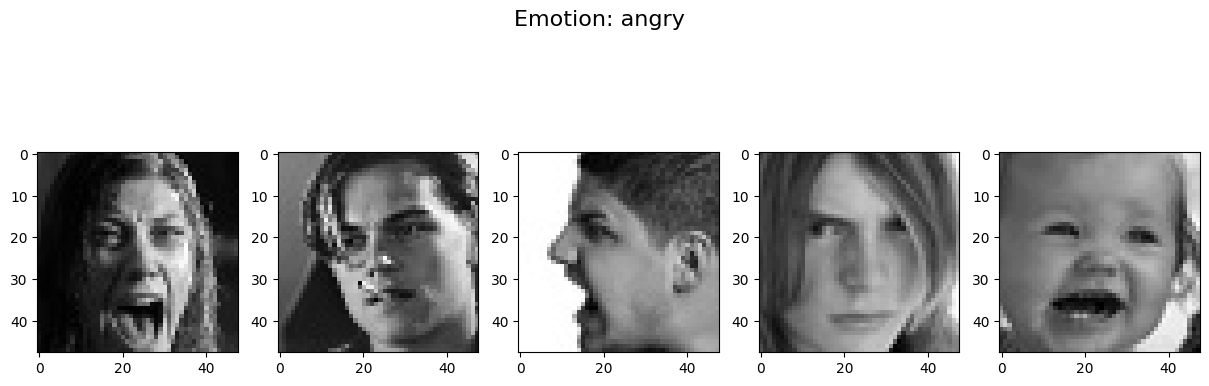

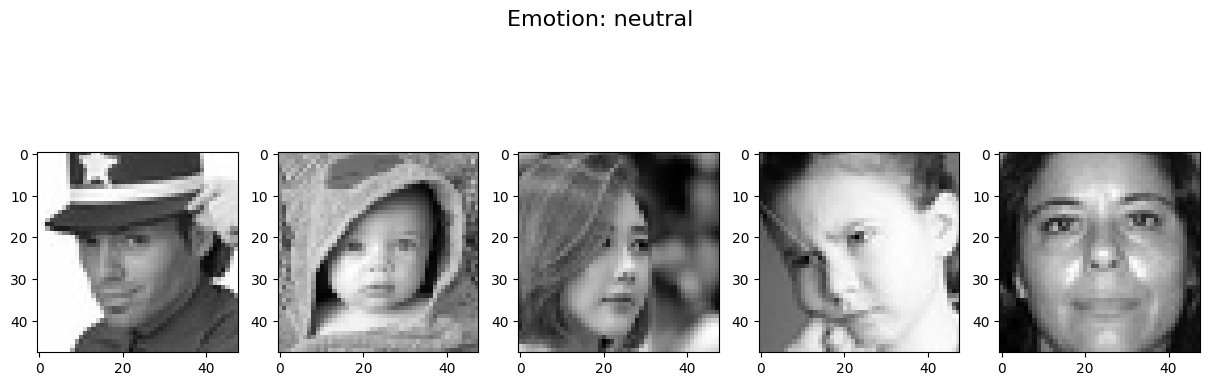

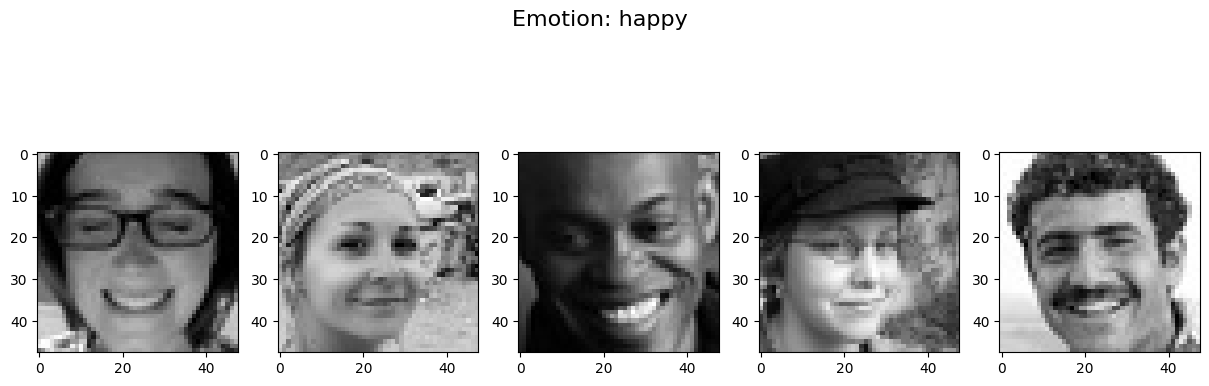

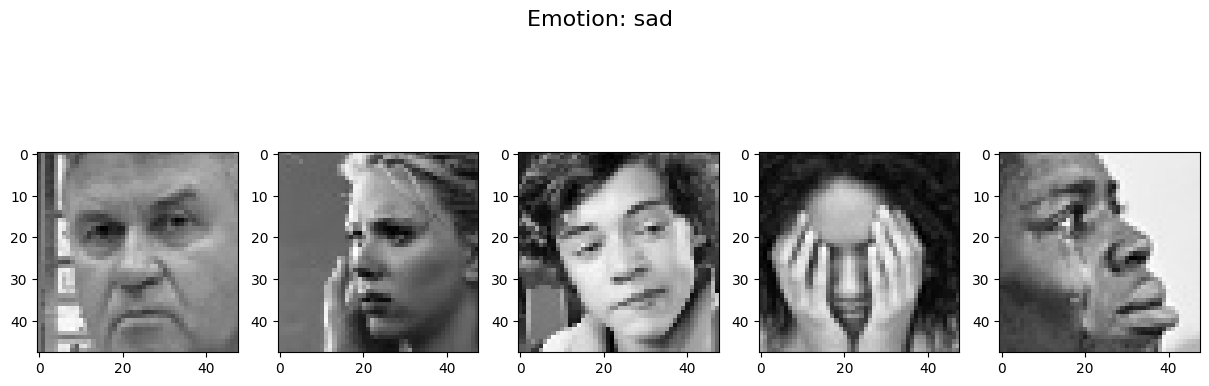

In [12]:
show_images_from_dataset(test_dir)

# ***8. Preprocessing the Combined Dataset***



*   Shape and batch size are defined
*   Images are normalized. (1 / 255)
*   Data augmentation applied.
*   Train set are shuffled. No need to shuffle test set.

In [13]:
img_shape = 224
batch_size = 32

train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 34186 images belonging to 4 classes.
Found 8510 images belonging to 4 classes.


##Balancing the dataset and checking counts


In [14]:
import os

data_dir = '/content/affectnet_preprocessed/train'
classes = ['neutral', 'happy', 'sad','angry']

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

print("Class counts before balancing:")
print(class_counts)


Class counts before balancing:
{'neutral': 4100, 'happy': 4035, 'sad': 2472, 'angry': 2574}


In [15]:
import random
from shutil import copyfile

min_class_count = min(class_counts.values())

# Create a new directory for balanced data
balanced_dir = '/content/affectnet_preprocessed/balanced_train'
os.makedirs(balanced_dir, exist_ok=True)

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    images = os.listdir(cls_dir)
    random.shuffle(images)

    selected_images = images[:min_class_count]  # Downsample to match the smallest class size

    # Create a directory for the class in the balanced dataset
    cls_balanced_dir = os.path.join(balanced_dir, cls)
    os.makedirs(cls_balanced_dir, exist_ok=True)

    for img in selected_images:
        src = os.path.join(cls_dir, img)
        dst = os.path.join(cls_balanced_dir, img)
        copyfile(src, dst)

print(f"Balanced dataset created at {balanced_dir}")


Balanced dataset created at /content/affectnet_preprocessed/balanced_train


In [16]:
balanced_class_counts = {cls: len(os.listdir(os.path.join(balanced_dir, cls))) for cls in classes}

print("Class counts after balancing:")
print(balanced_class_counts)


Class counts after balancing:
{'neutral': 2472, 'happy': 2472, 'sad': 2472, 'angry': 2472}


In [17]:
data_dir = balanced_dir  # Update the data directory to the balanced dataset
print(data_dir)

/content/affectnet_preprocessed/balanced_train


###Loading balanced dataset and performing a Custom CNN architecture

In [ ]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Load and preprocess your dataset
def load_data(image_size=(128, 128)):
    data_dir = "/content/affectnet_preprocessed/balanced_train"  # Change this to your dataset path
    datagen = ImageDataGenerator(rescale=1./255)

    data = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    X, y = zip(*(data[i] for i in range(len(data))))
    X = np.vstack(X)
    y = np.vstack(y)

    return X, y

# Load data
image_size = (128, 128)  # Try 96x96
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom CNN with adjusted architecture
def create_custom_cnn(input_shape=(128, 128, 3), num_classes=4):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.2),  # Increase alpha to help with dead neurons
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same'),
        LeakyReLU(alpha=0.2),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Conv2D(256, (3, 3), padding='same'),
        LeakyReLU(alpha=0.2),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        Conv2D(512, (3, 3), padding='same'),
        LeakyReLU(alpha=0.2),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.6),

        Flatten(),
        Dense(2048, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model
# Create the model
num_classes = 4
model = create_custom_cnn(input_shape=(image_size[0], image_size[1], 3), num_classes=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

# Display the model summary
model.summary()

# Set up callbacks for early stopping and learning rate reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

# Train the model with a smaller batch size to prevent memory overload
batch_size = 64
epochs = 350

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

In [19]:
#from sklearn.utils.class_weight import compute_class_weight
#import numpy as np
#
## Calculate class weights
#class_weights = compute_class_weight(
#    class_weight='balanced',
#    classes=np.unique(np.argmax(y_train, axis=1)),  # Get unique class indices from one-hot encoded labels
#    y=np.argmax(y_train, axis=1)  # Convert one-hot encoded labels back to class indices
#)
#
## Convert class weights to a dictionary
#class_weights = dict(enumerate(class_weights))
#print("Class Weights: ", class_weights)


In [20]:
# Evaluate the model on the validation set
results = model.evaluate(x_val, y_val)
val_loss, val_accuracy = results[0], results[1]  # Adjust according to the number of metrics

# If you used additional metrics like precision and recall:
if len(results) == 3:
    val_precision = results[2]
    print(f"Validation Precision: {val_precision * 100:.2f}%")
elif len(results) == 4:
    val_recall = results[3]
    print(f"Validation Recall: {val_recall * 100:.2f}%")

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


62/62 [==============================] - 5s 82ms/step - loss: 0.4356 - accuracy: 0.8185 - precision: 0.8246 - recall: 0.8104
Validation Recall: 81.04%
Validation Loss: 0.4355562627315521
Validation Accuracy: 81.85%


In [21]:
# For example, if you added precision and recall:
results = model.evaluate(x_val, y_val)
val_loss, val_accuracy, val_precision, val_recall = results

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_precision * 100:.2f}%")
print(f"Validation Recall: {val_recall * 100:.2f}%")


62/62 [==============================] - 5s 81ms/step - loss: 0.4356 - accuracy: 0.8185 - precision: 0.8246 - recall: 0.8104
Validation Loss: 0.4355562627315521
Validation Accuracy: 81.85%
Validation Precision: 82.46%
Validation Recall: 81.04%


#  **Plot the Curves**



*   Training and Validation Loss curves
*   Accuracy curves
*   Precision and Recall curves


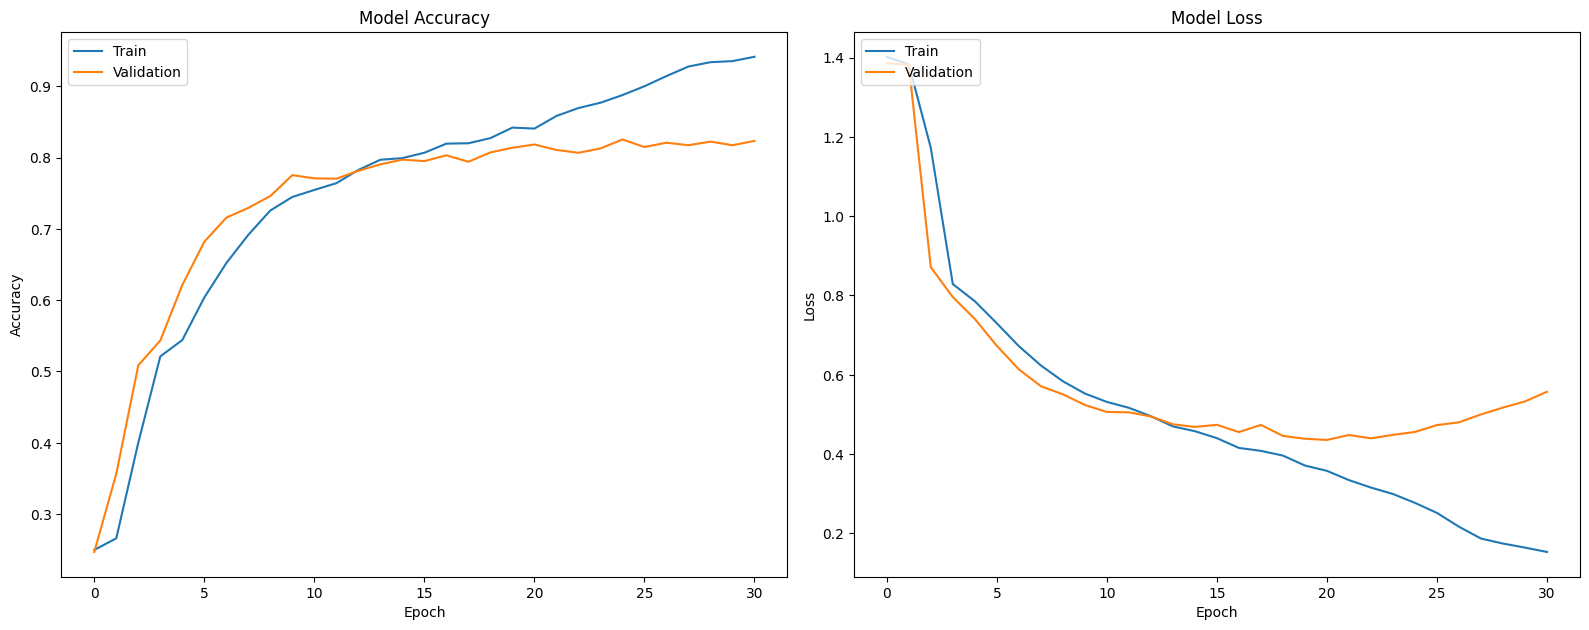

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

 #Plot training & validation precision values
#plt.plot(history.history['precision'])
#plt.plot(history.history['val_precision'])
#plt.subplot(2, 2, 3)
#plt.title('Model Precision')
#plt.xlabel('Epoch')
#plt.ylabel('Precision')
#plt.legend(['Train', 'Validation'], loc='upper left')
## Plot training & validation recall values
#plt.subplot(2, 2, 4)
#plt.plot(history.history['recall'])
#
#plt.plot(history.history['val_recall'])
#plt.title('Model Recall')
#plt.xlabel('Epoch')
#plt.ylabel('Recall')
#plt.legend(['Train', 'Validation'], loc='upper left')
 #Show plots
plt.tight_layout()
plt.show()


###Saving the trained model

In [23]:
# 1. Save the model
model.save('face_cnn8.h5')

# 2. Load the model (for future use)
from tensorflow.keras.models import load_model # Import the load_model function
model = load_model('face_cnn8.h5')
model.summary()

# 3. Download the model to your local system
from google.colab import files
files.download('face_cnn8.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Visualize Predictions***

1/1 [==============================] - 0s 49ms/step


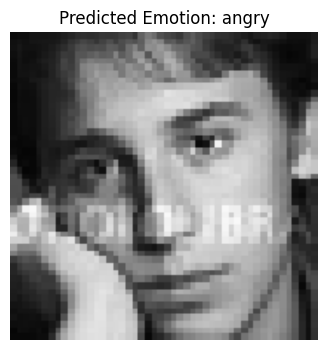

In [31]:
# Load a new image and preprocess it
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load a new image and preprocess it
img_path = '/content/dataset/test/neutral/PrivateTest_10767287.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

# Predict the emotion
predictions = model.predict(img_array_expanded)
predicted_class = np.argmax(predictions, axis=1)

class_labels = [ 'neutral', 'happy', 'sad','angry']
predicted_label = class_labels[predicted_class[0]]

# Display the image along with the predicted label
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Hide the axes
plt.show()


###Classification report

In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


62/62 [==============================] - 5s 75ms/step
              precision    recall  f1-score   support

     neutral       0.73      0.77      0.75       511
       happy       0.91      0.90      0.90       473
         sad       0.90      0.89      0.90       488
       angry       0.74      0.73      0.73       506

    accuracy                           0.82      1978
   macro avg       0.82      0.82      0.82      1978
weighted avg       0.82      0.82      0.82      1978



# ***Final Metrics***

62/62 [==============================] - 5s 76ms/step


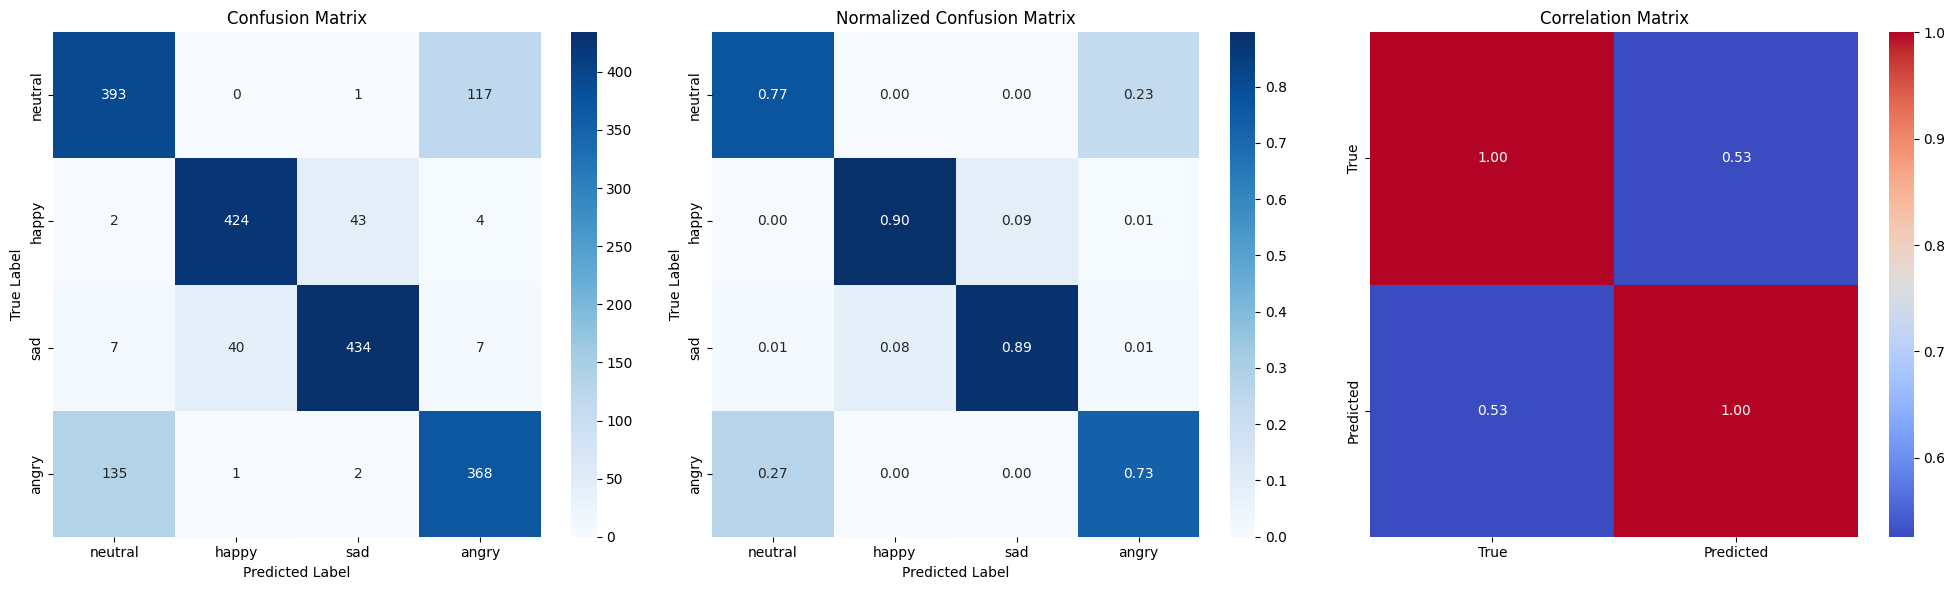

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Make predictions on the validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Convert true labels to class indices
y_val_classes = np.argmax(y_val, axis=1)  # Convert true labels to class indices

# 3. Compute the confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# 4. Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 5. Compute the correlation matrix
correlation_matrix = np.corrcoef(y_val_classes, y_pred_classes)

# 6. Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Adjust the figsize as needed

# 7. Plot the confusion matrix (unnormalized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

# 8. Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Normalized Confusion Matrix')

# 9. Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=['True', 'Predicted'], yticklabels=['True', 'Predicted'], ax=axes[2])
axes[2].set_title('Correlation Matrix')

# 10. Adjust layout to prevent overlap
plt.tight_layout()

# 11. Display the plots
plt.show()

In [27]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 8510 images belonging to 4 classes.


# ***18. Load Haar Cascade for Face Detection***

In [28]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2024-11-12 15:33:57--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2024-11-12 15:33:57 (14.9 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



# ***18. Predict different images from local***

1/1 [==============================] - 0s 125ms/step


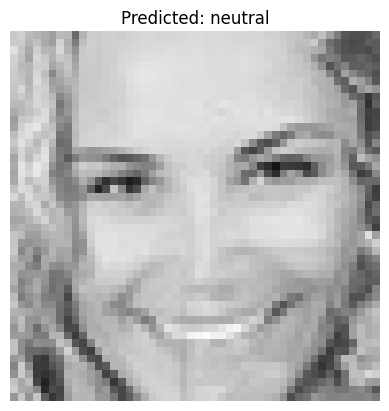

Predicted Label: neutral
Prediction Probabilities: [0.48336315 0.05098633 0.06520636 0.40044415]


In [29]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Define the class labels
labels = [ 'neutral', 'happy', 'sad','angry']

def preprocess_image(img_path, target_size=(128, 128)):
    """Load and preprocess an image."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

def predict_image(img_path):
    """Predict the class of an image."""
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    return labels[predicted_class], predictions[0]

def display_image_with_prediction(img_path, predicted_label):
    """Display the image with the predicted label."""
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Path to the local image
img_path = '/content/dataset/test/happy/PrivateTest_10077120.jpg'  # Update with the path to your image

# Predict and display the result
predicted_label, prediction_prob = predict_image(img_path)
display_image_with_prediction(img_path, predicted_label)

print(f'Predicted Label: {predicted_label}')
print(f'Prediction Probabilities: {prediction_prob}')
